In [1]:
!pip install spacy

     |████████████████████████████████| 9.9 MB 7.6 MB/s eta 0:00:01
     |████████████████████████████████| 119 kB 66.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 60.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.7 MB 51.7 MB/s eta 0:00:01
     |████████████████████████████████| 185 kB 67.1 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


Download Spacy spanish package as our comments are in spanish and need to be preprocessed ussing spanish vocabulary

In [2]:
!python -m spacy download es

     |████████████████████████████████| 16.2 MB 2.7 MB/s eta 0:00:01
  Created wheel for es-core-news-sm: filename=es_core_news_sm-2.3.1-py3-none-any.whl size=16216999 sha256=993c514e5112a7bda64bb63d4c6c787fd4db905542879e3c0c42198f92e99507
  Stored in directory: /tmp/pip-ephem-wheel-cache-y1f6l8xm/wheels/ef/67/82/0b6f50c9f4a2ad0e01633af17ece1d0bd8244f883385b1d9fa
Successfully built es-core-news-sm
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
✔ Linking successful
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/es_core_news_sm
-->
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/spacy/data/es
You can now load the model via spacy.load('es')


In [3]:
import numpy as np
import pandas as pd
import spacy
from io import StringIO
import os
from sklearn.feature_extraction import text
from string import punctuation
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction import text
import re
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from string import punctuation
import nltk
from nltk.corpus import stopwords
import unicodedata

# Load Spanish stopwords and natural language processing library.
all_stopword = list(stopwords.words("spanish")) + list(punctuation)
nlp = spacy.load('es', disable=['parser', 'ner'])  # make sure to use a larger model!


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:

# Read client's comments from data.xlsx
df = pd.read_excel('data.xlsx')

# Filter these data by the comments made from Hopsital source ("fuente" in spanish). 
# And remove those comments we won't use for the model.
df = df[((df["FUENTE"] != "CINESA OLD VERSION") & (df["FUENTE"] != "CINESA NEW VERSION") & (df["FUENTE"] != "THYSSEN "))]

# Comments with label POS (Positive), Negative or Other (Otros) are not useful for our intention of predict specific comments about cocnrete hospital complaints
df = df[(df["Codigo_new"]!= "POS") & (df["Codigo_new"]!= "NEGATIVA") & (df["Codigo_new"]!= "OTROS")]

# Calculate label's count and leaving only the comments which label have at least 30 comments
def long_short(x):
    df_long= pd.DataFrame(df["Codigo_new"].value_counts()>=30)
    df_long["Label"]= df_long.index
    df_long= df_long[df_long["Codigo_new"]]
    list_of_labels = list(df_long["Label"])
    if x in list_of_labels:
        return "Y"
    else:
        return "N"
    
# Apply function to create a column  Y/N to filter by labels that we want to use to train the model. 
df["Short_Long"] = df["Codigo_new"].apply(long_short)
df = df[df["Short_Long"] == "Y"]

df= df.sort_values("Codigo_new")

# Short the dataframe by leaving just two columns: the comments and the labels.
col = ['Codigo_new', 'Comentarios_ES']
df = df[col]
df = df[pd.notnull(df['Comentarios_ES'])]

# enlabel comments tags into numbers (category_ids)
df['category_id'] = df['Codigo_new'].factorize()[0]

#Created different variables to store category_id and comment Label.
category_id_df = df[['Codigo_new', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Codigo_new']].values)



#Create a length column for the comments in case we need them to train the model.
splitter = lambda x: len(str(x).split())
splitter_letter = lambda x: len(str(x))
df["length_split"] = df["Comentarios_ES"].apply(splitter)
df["length_letters"] = df["Comentarios_ES"].apply(splitter_letter)  



### Preprocessing:

In [5]:
# Function to remove stopwords from comments:
def removeStopwords(words):
    important_words=[]
    seperator = ' '
    for word in words.split():
        if word not in all_stopword:
            important_words.append(word)
    return seperator.join(important_words)

# Function to remove accents from comments:
def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

# Function to lemmatize the comments:
def lemmatizacion(comment): # ,allowed_postags=['NOUN', 'ADJ', 'VERB',"PROPN"]
    phrase= []
    for word in comment.split():
        doc = nlp(word)
        #if doc[0].pos_ in allowed_postags:
        phrase.append(doc[0].lemma_)
    return " ".join(phrase)


#from spellchecker import SpellChecker
#spell = SpellChecker(language="es")

# Function to autocorrect the comments:
def autocorrector(x):
    misspelled = spell.unknown(str(x).split())
    sentence = x
    for wd in misspelled:
    # Get the one `most likely` answer
        sentence= sentence.replace(wd,spell.correction(wd))
    return sentence   


In [6]:

def dataframe_processing(df):
    """ Transform string text to a format that the model can read 
    args:
    df (Dataframe) takes a dataframe with comments
    return: a dataframe with comments without stopwords, in lowercase and stemmed."""
    
    
    corpus = []
    for i in df['Comentarios_ES'].index:
        review = df['Comentarios_ES'][i]
        
        # Transform each review to lowercase and append it to a list of reviews (corpus)
        review = str(review).lower()
        corpus.append(review)
        
    # Create a new column on our dataframe with the new lowercase comments called CleanComment:
    df["CleanComment"]  = corpus
    
    # Remove stopwords.
    df["CleanComment"] = df["CleanComment"].apply(removeStopwords)
    
    
    corpus2 = []
    
    # Go through again to each review, split it in words and stem each word.
    for i in df['CleanComment'].index:
        review = df['CleanComment'][i]
        review = review.split()
        ps = SnowballStemmer("spanish")
        review = [ps.stem(word) for word in review if not word in set(all_stopword)]
        
        # then join with spaces each word and append it to the list of reviews (corpus2)
        review = ' '.join(review)
        corpus2.append(review)
        
    # Set the column CleanComments to corpus2
    df['CleanComment'] = corpus2
    df["CleanComment"]= df["CleanComment"].apply(strip_accents)
    
    corpus3 = []
    # Finally remove punctuation and symbols from each review.
    for i in df['CleanComment'].index: 
        review = re.sub('[^a-zA-Z]', ' ', df['CleanComment'][i])
        corpus3.append(review)
    df["CleanComment"]= corpus3
    
    return df

    

In [7]:
df= dataframe_processing(df)

In [7]:
#create a data directory to save preprocessed df.
data_dir = "Label_predictor"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [63]:
# Save processed comments to data_dir
df.to_csv(os.path.join(data_dir,"clencomments.csv"),index=False,header=True)

In [8]:
# Read processed comments  from data_dir
df= pd.read_csv(os.path.join(data_dir,"clencomments.csv"),header=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2405 entries, 0 to 2404
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Codigo_new      2405 non-null   object
 1   Comentarios_ES  2405 non-null   object
 2   category_id     2405 non-null   int64 
 3   length_split    2405 non-null   int64 
 4   length_letters  2405 non-null   int64 
 5   CleanComment    2384 non-null   object
dtypes: int64(3), object(3)
memory usage: 112.9+ KB


In [9]:
# Drop empty comments giving by the result of removing stopwords.
df=df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2384 entries, 0 to 2404
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Codigo_new      2384 non-null   object
 1   Comentarios_ES  2384 non-null   object
 2   category_id     2384 non-null   int64 
 3   length_split    2384 non-null   int64 
 4   length_letters  2384 non-null   int64 
 5   CleanComment    2384 non-null   object
dtypes: int64(3), object(3)
memory usage: 130.4+ KB


### Analysis:

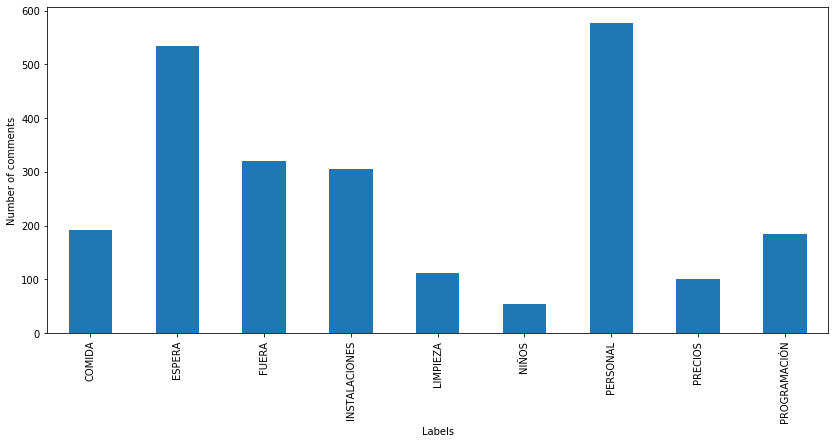

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Check comments count by label.
# To see if there are unbalanced classes we need to take into account when training the model:

fig = plt.figure(figsize=(14,6))
df.groupby('Codigo_new')["CleanComment"].count().plot.bar(ylim=0)
plt.xlabel("Labels")
plt.ylabel("Number of comments")
plt.show()

Text(0, 0.5, 'Length of comments')

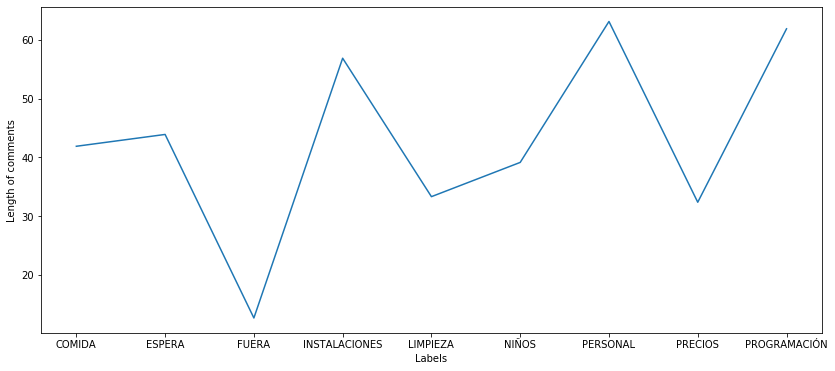

In [14]:
# Check comments length by label. We might want to include this data to the model.
fig = plt.figure(figsize=(14,6))
df_ =df.copy()
df_.groupby("Codigo_new").mean()["length_letters"].plot()
plt.xlabel("Labels")
plt.ylabel("Length of comments")

Create a word count file to see which most common and uncommond words that happen in the file or if need word must be added to the stopword list. 
For instance, Using TFIDF (short for term frequency–inverse document frequency) from Sklearn library. 
TFIDF measures not only the term count of a comment, but also the frequency compensating the most and 
less used terms along the data frame.

In [15]:
words =[]
for text in df["CleanComment"]:
    for word in str(text).split():
        words.append(word)
        
pd.DataFrame(words)[0].value_counts().to_excel(os.path.join(data_dir,"wordcount-CleanComment.xlsx"))

#SLUG 
words =[]
for text in df["Comentarios_ES"]:
    for word in str(text).split():
        words.append(word)
        
pd.DataFrame(words)[0].value_counts().to_excel(os.path.join(data_dir,"wordcount.xlsx"))


In [16]:
""" N-GRAMS"""
# Extract file's n-grams words to see which ngrams the document have.
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
x= df["CleanComment"]
y= df["Codigo_new"]

counter = CountVectorizer(vocabulary=None,ngram_range=(2, 2), analyzer='word')
x_counter= counter.fit_transform(x.values)
terms =pd.DataFrame(x_counter.toarray(),columns=counter.get_feature_names()).sum()
terms.to_excel(os.path.join(data_dir,"ngrams.xlsx"))

In [18]:
from sklearn.metrics import confusion_matrix,classification_report,average_precision_score,precision_score,recall_score,accuracy_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.svm import LinearSVC



Benchmark Result.
How I chose and defined an efficient model to do this task was researching on the internet which algorithm would be the best for labeling in text analytics. I found all kinds of examples but none similar to my problem. The most interesting was Sentiment analysis, however it just defines whether a review infers a Positive or Negative sentiment. I needed an algorithm that predicts many labels based on different comments. 

Nevertheless, Sentiment Analysis was the key to acknowledge what processes and techniques I would need in order to build a model that predicts various comments label. The basis of sentiment analysis is that it goes through each comment and it counts each word, so that comments that contains certain words have a more positive or negative inclination then it sums the numbers and determinates whether the review has more Negative or Positive words, you can do that using the library “Vader”.

The logic behind my Comment Adivine is similar. Comments with same or similar words would belong to the same Label. I would need a library that counts each word and their frequency, that’s where TFIDF from Sklearn comes into play. Then I have a matrix of word’s count and frequency, therefore I would need a model that could read a matrix or vectors.

I found two solutions:

#### A Supervised model
#### Or an Unsupervised model.

I thought that an Unsupervised model would be easier to train, as I wouldn’t need labels in the first place. I did some research and found a library that could help to predict topics based on papers or reviews, LatentDirichletAllocation from Sklearn. I immediately noticed that this kind of models doesn’t work with short comments. As they predict topics or groups of what the comments are about. It is quite hard to get an idea of what such a short comment is intended to belong in terms of topics: Check results and visualization.


In [48]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(vocabulary=None,ngram_range=(2, 2), analyzer='word')
x_tdf = vectorizer.fit_transform(x)
x_tdf

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=9, algorithm='randomized', n_iter=300)
svd_model.fit(x_tdf)

terms = vectorizer.get_feature_names()

# Get the most frequent terms in each Topic that the model predicted.
for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
        print(" ")


Topic 0: 
tiemp esper
 
men tiemp
 
esper consult
 
esper demasi
 
esper urgenci
 
esper mas
 
esper hor
 
Topic 1: 
sal esper
 
personal medic
 
sill sal
 
mes personal
 
esper sal
 
espaci sal
 
pon air
 
Topic 2: 
personal medic
 
mes personal
 
medic enfermer
 
gust personal
 
medic sanitari
 
sobretod tiemp
 
mas necesari
 
Topic 3: 
mes personal
 
medic sanitari
 
metgets infermer
 
personal metgets
 
grand comarc
 
instal grand
 
personal instal
 
Topic 4: 
list esper
 
esper ano
 
reduc list
 
rapidez reduc
 
complementari quirofan
 
esper explor
 
explor complementari
 
Topic 5: 
ser mas
 
mas amabl
 
amabl pacient
 
ser amabl
 
mas rap
 
mas simpat
 
mas personal
 
Topic 6: 
mejor instal
 
deb mejor
 
personal eficaz
 
instal personal
 
antigu mejor
 
hospital antigu
 
instal oncolog
 
Topic 7: 
ser amabl
 
amabl pacient
 
personal recepcion
 
amabl secret
 
recepcion pod
 
ser atend
 
pod ser
 
Topic 8: 
varied menu
 
mas varied
 
varied com
 
mes plat
 
menu mes
 
plat menu

In [41]:
! pip install umap-learn # try "pip install umap" if you get an error in the cell below 

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


Let's visualize those terms in a graph with their respective Label to compare whether predicted topic and original Label are grouped together

Text(0, 0.5, 'Embedding 1')

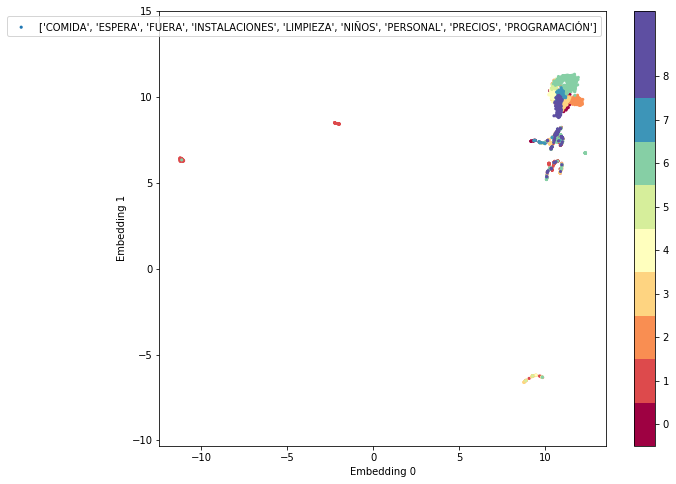

In [51]:
import umap
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

prediction_labels = {"COMIDA":0.0,
"ESPERA":1.0,"FUERA":2.0,"INSTALACIONES":3.0,"LIMPIEZA":4.0,"NIÑOS":5.0,"PERSONAL":6.0,"PRECIOS":7.0,"PROGRAMACIÓN":8.0}


X_topics = svd_model.fit_transform(x_tdf)
embedding = umap.UMAP(n_neighbors=20, min_dist=0.1, random_state=12,n_components=8).fit_transform(X_topics)
plt.figure(figsize=(10,8))
plt.scatter(embedding[:, 0], embedding[:, 1], 
c=y.map(prediction_labels) ,
cmap='Spectral',           
s = 10, # size
edgecolor='none'
)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(9))
plt.legend([['COMIDA','ESPERA','FUERA','INSTALACIONES','LIMPIEZA','NIÑOS','PERSONAL','PRECIOS','PROGRAMACIÓN']])
plt.xlabel("Embedding 0")
plt.ylabel("Embedding 1")

Comments from different Labels show mixed up with others, there is no clear separation between comments belonging to different Labels.

In [54]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
cv= TfidfVectorizer(max_df =0.6,min_df = 2,stop_words=all_stopword)# not unique min_df = 2
dtm = cv.fit_transform(df["CleanComment"])

from sklearn.decomposition import LatentDirichletAllocation
LDA = LatentDirichletAllocation(n_components=9) # Number of topics I would like to predict. 9 Since I have to predict 9 differnet Labels.
LDA.fit(dtm)
LDA.components_.shape

(9, 928)

In [55]:
# Get topcis most frequent words from model components.
for i,topic in enumerate(LDA.components_):
    print(f"Top 15 words for topic #{i}")
    print([cv.get_feature_names()[index] for index in topic.argsort()[-15:]])
    print("\n")

Top 15 words for topic #0
['pon', 'deb', 'mayor', 'atencion', 'mal', 'mas', 'mejor', 'pod', 'calid', 'enfermer', 'ser', 'varied', 'amabil', 'atend', 'com']


Top 15 words for topic #1
['part', 'mitjans', 'hac', 'graci', 'ten', 'cos', 'personal', 'profesional', 'si', 'mas', 'bien', 'bocadill', 'sol', 'falt', 'horari']


Top 15 words for topic #2
['larg', 'nin', 'deberi', 'demasi', 'dar', 'mied', 'atend', 'acer', 'enferm', 'pacient', 'cambi', 'esper', 'sal', 'rapidez', 'personal']


Top 15 words for topic #3
['varied', 'jueg', 'consult', 'informacion', 'plat', 'doctor', 'baj', 'gent', 'tard', 'telefon', 'mas', 'urgenci', 'pon', 'cit', 'preci']


Top 15 words for topic #4
['necesit', 'ser', 'ano', 'ir', 'buen', 'atencion', 'mas', 'list', 'favor', 'limpi', 'rap', 'esper', 'limpiez', 'sal', 'puntual']


Top 15 words for topic #5
['recurs', 'sanitari', 'personal', 'agu', 'pag', 'empat', 'litr', 'zum', 'mes', 'vari', 'sill', 'cafet', 'client', 'mejor', 'atencion']


Top 15 words for topic #6


Text(18.92611111111112, 0.5, 'Number of comments')

<Figure size 720x288 with 0 Axes>

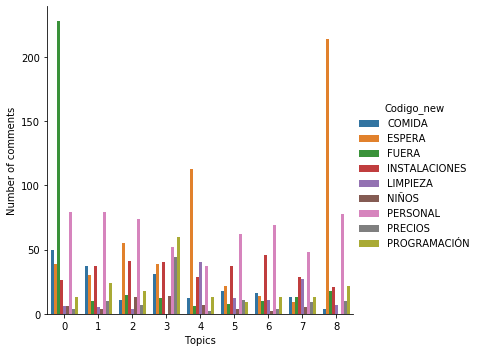

In [64]:
# Create a column in the Data frame with the topic number the model predicted to the comment.
topic_results= LDA.transform(dtm)
df["Topic"] = topic_results.argmax(axis=1)

# Plot the results to see Topics distribution in comparision to orginal data set labels ("Codigo_new").
plt.figure(figsize=(10,4))
sns.catplot("Topic",data=df,kind="count",hue="Codigo_new")
plt.xlabel("Topics")
plt.ylabel("Number of comments")

As you can see, Topics are mixed up between multiple different labels. This might be because of the length of the comments,  which doesn't allow the model to identify a document (comment) as a single topic because is not long enough to comprehend the context and make a full matrix of words to compare to.

After getting an idea about how my data is distributed, I considered that a Supervised model would be the best choice. I will work with vectors as my project is like that of sentiment analysis paper that I studied on Udemy course: “NLP – Natural Language Processing with Python”. So, I decided to go for vector model as the course recommended. I simply compared different vectors models to see which one would give a better accuracy in a raw test. Here are the results:

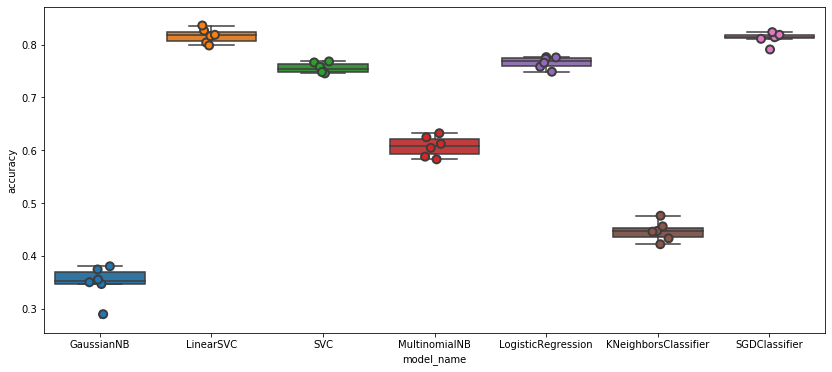

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB,GaussianNB

from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.svm import LinearSVR
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
tfidf= TfidfVectorizer()
features = tfidf.fit_transform(df["CleanComment"]).toarray()
labels = df.category_id

fig = plt.figure(figsize=(14,6))
models = [
    GaussianNB(),
    LinearSVC(),
    SVC(),
    MultinomialNB(),
    LogisticRegression(),KNeighborsClassifier(),SGDClassifier(),
]
CV = 6
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

Linear SVC proven the algorithm with most accuracy in comparison to other models.

I believe a vector based algorithm is a good approach for this issue as it will transport a matrix of term frequency vectors to a 2 or 3 dimensional plane where the comments with similar term frequency of words would be close to each other and share the same labels. These kind of models allow to predict multiple classes, models such as Logistic Regression don’t work well with too many classes.



After I selected the most efficient model for my data (Linear SVC) I trained a provisional model in the notebook instance using Sklearn package to make some arrangements.


In [70]:
"""  PIPELINE Model """
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test =  train_test_split(x,y, test_size=0.3,random_state= 217)

# Create a Pipeline Linear SVC model.
clf = Pipeline([("tfidf",TfidfVectorizer(vocabulary=None,analyzer="word",lowercase=True)),("clf",LinearSVC())])
clf.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
               

After training this model I take this provisional model vocabulary and sorted it by their coefficients. . I also considered an optional function called update_vocabulary() that would update model’s vocabulary adding the words I considered important for the model. But didn’t apply it.

Then I plot a graph that calculates accuracy according to the length of the sorted vocabulary. Then I did the same with the number of N-grams range my TfidfVectorizer object would take.


In [71]:
# GET VOCABULARY SORTED BY MODEL COEFICIENTS

def get_model_vocab(model,n_features):
    """ This function takes a trained model and returns it's vectorize vocabulary
    args:
    model (a Pipeline LinearSVC model with TfidfVectorizer): the trained model using a Pipeline function
    
    return: 
    vocabulary of the train data as a dictionary"""
    
    coefs = model.named_steps["clf"].coef_
    if type(coefs) =="csr_matrix":
        coefs.toarray().tolist()[0]
    else:
        coefs.tolist()
    feature_names = model.named_steps["tfidf"].get_feature_names()
    coefs_and_features = list(zip(coefs[0],feature_names))
    top_feats = sorted(coefs_and_features, key=lambda x: abs(x[0]), reverse=True)[:n_features]
    vocab = {x[1]: i for i, x in enumerate(top_feats)}
    return vocab

#  UPDATE VOCABULARY WITH new N-GRAMS words (Optional)
def update_vocabulary(string):
    """ This function takes a strings series separated by commas and adds each word or ngrams into the model's vocabulary.
    args:
    string (string): the series of string or strings separates by commas.
    
    return: 
    updated vocabulary of the train data as a dictionary"""
    vocab_2ngram = string.split(",")
    vocab_2ngram_dict = {}
    for i,word in zip(range(len(vocab),len(vocab)+len(vocab_2ngram)),vocab_2ngram):
        vocab_2ngram_dict.update({word:i})
    vocab_2ngram_dict
    vocab.update(vocab_2ngram_dict)
    return vocab

string = "urgenci esper,tiemp esper,temps esper,sal esper,personal medic,hor esper,esper urgenci,falt personal,list esper,cambi personal,esper consult,esper hor,air acondicion,do hor,esper visit,necesit personal,baix preus,buen atencion,esper demasi,esper sal,trat human,varied product,atencion client"

vocab = get_model_vocab(clf,5000)



Plot a graph that calculates accuracy according to the length of the sorted vocabulary and the number of N-grams range my TfidfVectorizer object would take:

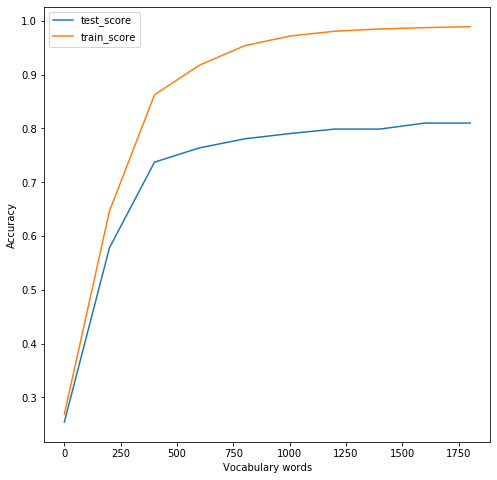

In [72]:
from sklearn import model_selection
import pickle
import itertools
import matplotlib.pyplot as plt

""" VOCABUALRY SIZE VS MODEL EFFICIENCY """

test_score_precision1 = []
test_score_prediction1 = []
train_score1 = []
test_score1 = []
for depth in range(1,2000,200):
    clf = Pipeline([("tfidf",TfidfVectorizer(vocabulary=dict(itertools.islice(vocab.items(), depth)),analyzer="word",lowercase=True)),("clf",LinearSVC())])
    clf.fit(x_train,y_train)

    rfc_pred = clf.predict(x_test)
    train_score1.append(clf.score(x_train,y_train))
    test_score1.append(clf.score(x_test,y_test))

plt.figure(figsize = (8,8))
plt.plot( range(1,2000,200), test_score1)
plt.plot( range(1,2000,200), train_score1)
plt.xlabel('Vocabulary words')
plt.ylabel('Accuracy')
plt.legend(["test_score","train_score"])

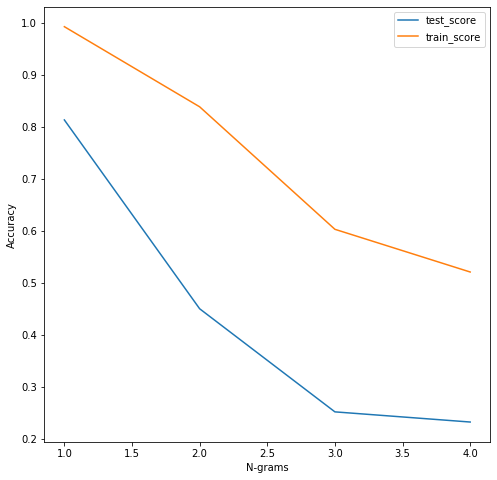

In [73]:
""" # NGRAMS  VS MODEL EFFICIENCY """


test_score_precision1 = []
test_score_prediction1 = []
train_score1 = []
test_score1 = []
for n in range(1,5,1):
    clf = Pipeline([("tfidf",TfidfVectorizer(ngram_range=(n,n),analyzer="word",lowercase=True)),("clf",LinearSVC())])
    clf.fit(x_train,y_train)

    rfc_pred = clf.predict(x_test)
    train_score1.append(clf.score(x_train,y_train))
    test_score1.append(clf.score(x_test,y_test))

plt.figure(figsize = (8,8))

plt.plot( range(1,5,1), test_score1)
plt.plot( range(1,5,1), train_score1)
plt.xlabel('N-grams')
plt.ylabel('Accuracy')
plt.legend(["test_score","train_score"])

Finally, trained the provisional model using that insight and calculated model metrics:

In [74]:
text_clf = Pipeline([("tfidf",TfidfVectorizer(vocabulary = None,ngram_range=(1,1),analyzer="word",lowercase=True)),("clf",LinearSVC())])
text_clf.fit(x_train,y_train)

predictions = text_clf.predict(x_test)
print(classification_report(y_test,predictions))

print("Model accuracy: {}. Recall: {}. Precision: {}".format(round(accuracy_score(predictions,y_test),2),round(recall_score(predictions,y_test,average="weighted"),2),round(precision_score(predictions,y_test,average="weighted"),2)))



               precision    recall  f1-score   support

       COMIDA       0.92      0.84      0.88        69
       ESPERA       0.88      0.90      0.89       160
        FUERA       0.66      0.86      0.74        85
INSTALACIONES       0.76      0.66      0.71        91
     LIMPIEZA       0.93      0.87      0.90        31
        NIÑOS       0.73      0.84      0.78        19
     PERSONAL       0.78      0.78      0.78       161
      PRECIOS       0.88      0.81      0.85        37
 PROGRAMACIÓN       0.89      0.76      0.82        63

     accuracy                           0.81       716
    macro avg       0.83      0.81      0.82       716
 weighted avg       0.82      0.81      0.81       716

Model accuracy: 0.81. Recall: 0.81. Precision: 0.82


MODEL accuracy, recall and precision quite high, 80%. I believe this performance is valid to our purpose, taking in mind that some comments are ambiguous and they might belong to more than one category. Due to that, I decided to calculate how predictions and real labels are distributed.

See in the below graph how comments predictions are distribuited:

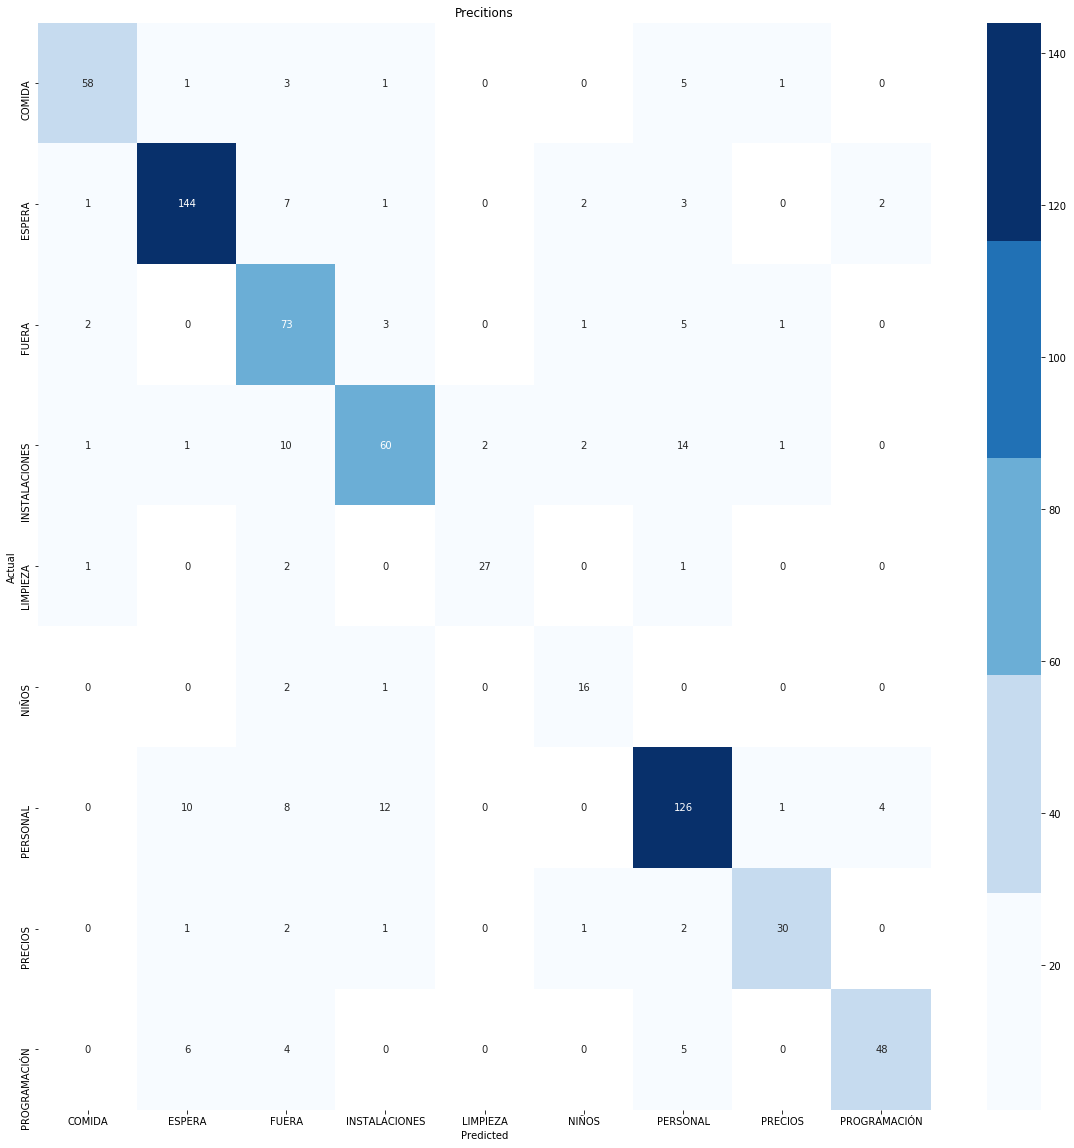

In [75]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, predictions)
fig, ax = plt.subplots(figsize=(20,20))

cmap = plt.get_cmap('Blues',5)
cmap.set_under('white')#Colour values less than vmin in white
cmap.set_over('blue')# colour valued larger than vmax in red 
sns.heatmap(conf_mat, annot=True, fmt='d',cmap=cmap,
            xticklabels=category_id_df.Codigo_new.values, yticklabels=category_id_df.Codigo_new.values,linecolor="grey",vmin=1)
plt.title("Precitions")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Then I check if the training examples were correctly labeled, so I created a dataframe with the comments, the real label and the prediction label and check one by one whether the prediction label was more accurate that the real one. After all, the data was manually labeled by humans and they might be errors as well on labeling them.

Doing this I noticed that some comments belong much more to the predicted label than to the real label they had, meaning that some comments were mislabeled at the beginning. So I went through the original training data set (data.xlsx) and manually check whether the comments were accordingly labeled and corrected the labels in case it wasn’t properly done. Then run the whole code again.

Doing this improved my model precision.

In [76]:
predictions_df = pd.DataFrame([x_test.values,y_test.values,predictions]).T
predictions_df.columns=  ["Comment","Real Label","Predicted Label"]
predictions_df.to_csv(os.path.join(data_dir,"Predictions Labels Check.csv"))

### Modeling 
It is time to set up the model using AWS.

In [77]:
""" USING PIPEPILE"""

# Prepare train and test data to save it in our directory.
train_Pipeline = pd.concat([pd.DataFrame(y_train),pd.DataFrame(x_train)],axis=1)
test_Pipeline = pd.concat([pd.DataFrame(y_test),pd.DataFrame(x_test)],axis=1)

train_data_y_Pipe= train_Pipeline["Codigo_new"].values
train_data_x_Pipe= train_Pipeline["CleanComment"].values

test_data_y_Pipe= test_Pipeline["Codigo_new"].values
test_data_x_Pipe= test_Pipeline["CleanComment"].values


In [78]:

# Create a function to save the training and test data into our data  directory.
def make_csv(x, y, filename, data_dir):
    '''Merges features and labels and converts them into one csv file with labels in the first column.
       :param x: Data features
       :param y: Data labels
       :param file_name: Name of csv file, ex. 'train.csv'
       :param data_dir: The directory where files will be saved
       '''
    # make data dir, if it does not exist
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    
    # your code here
    df = pd.concat([pd.DataFrame(y),pd.DataFrame(x)],axis=1)
    df.to_csv(os.path.join(data_dir,filename),index=False,header=False)
    
    # nothing is returned, but a print statement indicates that the function has run
    print('Path created: '+str(data_dir)+'/'+str(filename))
    return df

In [79]:
make_csv(train_data_x_Pipe,train_data_y_Pipe,"train_Pipe.csv",data_dir)

Path created: Label_predictor/train_Pipe.csv


,0,0
0,ESPERA,rapidez
1,FUERA,ae
2,LIMPIEZA,limpi
3,PERSONAL,atencion client
4,FUERA,gust minkr v jajaj equisd lol put k leer despu...
...,...,...
1663,INSTALACIONES,sill mal parec mentir ten herramient tan impor...
1664,FUERA,foii q
1665,ESPERA,reduc lisr esper tiemp esper consult
1666,ESPERA,medic urgenci normal ven urgenci esper hor hor...


In [80]:
make_csv(test_data_x_Pipe,test_data_y_Pipe,"test_Pipe.csv","Label_predictor")

Path created: Label_predictor/test_Pipe.csv


,0,0
0,PERSONAL,personal recepcion pod ser amabl
1,INSTALACIONES,jor estanci enferm
2,PERSONAL,atencion
3,PERSONAL,informacion
4,COMIDA,com vegetarian vegan carn
...,...,...
711,PERSONAL,amabil respet
712,INSTALACIONES,sal esper discret moderniz mobiliari
713,ESPERA,pumtual
714,PERSONAL,informacion


In [81]:

import pandas as pd
import boto3
import sagemaker

In [82]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

In [83]:

# set prefix, a descriptive name for a directory  
prefix = 'Label_predictor'

# upload all data to S3 

training = sagemaker_session.upload_data(os.path.join(data_dir,"train_Pipe.csv"),bucket=bucket, key_prefix=prefix)
testing = sagemaker_session.upload_data(os.path.join(data_dir,"test_Pipe.csv"),bucket=bucket, key_prefix=prefix)

print(training)

s3://sagemaker-eu-central-1-915492785002/Label_predictor/train_Pipe.csv


In [84]:
#Chekcthat data was succesfully uploaded to s3


# confirm that data is in S3 bucket
empty_check = []
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)
    print(obj.key)

assert len(empty_check) !=0, 'S3 bucket is empty.'
print('Test passed!')

Label_predictor/clencomments.csv
Label_predictor/ngrams.xlsx
Label_predictor/test.csv
Label_predictor/test_Pipe.csv
Label_predictor/train.csv
Label_predictor/train2.csv
Label_predictor/train_Pipe.csv
Label_predictor/wordcount-CleanComment.xlsx
Label_predictor/wordcount.xlsx
plagiarism/train.csv
sagemaker-scikit-learn-2020-10-13-14-46-07-889/debug-output/training_job_end.ts
sagemaker-scikit-learn-2020-10-13-14-46-07-889/source/sourcedir.tar.gz
sagemaker-scikit-learn-2020-10-13-15-45-53-769/source/sourcedir.tar.gz
sagemaker-scikit-learn-2020-10-13-15-51-45-689/source/sourcedir.tar.gz
sagemaker-scikit-learn-2020-10-13-15-55-24-411/source/sourcedir.tar.gz
sagemaker-scikit-learn-2020-10-13-15-59-26-028/source/sourcedir.tar.gz
sagemaker-scikit-learn-2020-10-13-16-16-33-182/source/sourcedir.tar.gz
sagemaker-scikit-learn-2020-10-13-16-28-36-829/source/sourcedir.tar.gz
sagemaker-scikit-learn-2020-10-13-16-34-23-451/source/sourcedir.tar.gz
sagemaker-scikit-learn-2020-10-13-16-38-48-306/debug-out

Modify the predict_fn() in the script.py in order it takes as input_data a string of comments separated by commas and splits it to create a list of strings so the model can read it and return the predictions as a single string of predictions separated by commas.

I need to test the prediction function to know what data type the models accepts to make predicitons. So I played with different formats and transformed the train and test data.

For instance, the prediction function only accepts an array of strings. Since from Lamba I will send a single string I needed that the predict_fn did some preprocessing and transform that single string into an array of strings to make predictions. Then it will join each string with commas because the output must be sent to lambda, and lambda won't read arrays.

See functions below:

In [85]:
!pygmentize source_train/script.py

from __future__ import print_function

import argparse
import os
import pandas as pd
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

allow_pickle = True
from sklearn.externals import joblib

## TODO: Import any additional libraries you need to define a model
from sklearn.svm import LinearSVC

# Provided model load function
def model_fn(model_dir):
    """Load model from the model_dir. This is the same model that is saved
    in the main if statement.
    """
    print("Loading model.")
    
    
    # load using joblib
    model = joblib.load(os.path.join(model_dir, "model.joblib"))
    print("Done loading model.")
    
    return model


## TODO: Complete the main code
if __name__ == '__main__':
    
    # All of the model parameters and training parameters are sent as arguments
    # when this script is executed, during a training job
    
    # Here we set up an argument parser to easily access the par

In [86]:

from sagemaker.sklearn.estimator import SKLearn

# Create a Sklearn estimator
estimator = SKLearn(entry_point="script.py",
                    source_dir="source_train",
                    role=role,
                    train_instance_count=1,
                    train_instance_type='ml.c5.xlarge',
                   sagemaker_session=sagemaker_session)

This is not the latest supported version. If you would like to use version 0.23-1, please add framework_version=0.23-1 to your constructor.


In [87]:
%%time

# Train your estimator on S3 training data,
estimator.fit({'train': training,'test': testing})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-10-22 11:19:04 Starting - Starting the training job...
2020-10-22 11:19:07 Starting - Launching requested ML instances......
2020-10-22 11:20:12 Starting - Preparing the instances for training...
2020-10-22 11:21:04 Downloading - Downloading input data
2020-10-22 11:21:04 Training - Downloading the training image...
2020-10-22 11:21:30 Uploading - Uploading generated training model
2020-10-22 11:21:30 Completed - Training job completed
2020-10-22 11:21:18,464 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2020-10-22 11:21:18,467 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-10-22 11:21:18,475 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-10-22 11:21:18,680 sagemaker-containers INFO     Module script does not provide a setup.py. 
Generating setup.py
2020-10-22 11:21:18,680 sagemaker-containers INFO     Generating setup.cfg
2020-10-22 11:21:18,680 sagemaker-containers INFO 

In [88]:

%%time

# deploy your model to create a predictor
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.t2.medium') # 'ml.c5.large'  ml.t2.medium  ml.m4.xlarge

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!CPU times: user 262 ms, sys: 8.11 ms, total: 270 ms
Wall time: 7min 31s


In [89]:
# We need to copy this endpoint name to our lambda function
predictor.endpoint

'sagemaker-scikit-learn-2020-10-22-11-19-04-344'

### Create a Lambda Function
This Lambda function will be executed whenever our public API has data sent to it. When it is executed it will receive the data, perform any sort of processing that is required, send the data (the review) to the SageMaker endpoint we've created and then return the result.

Take in mind that the lambda functions may need some additional layers containing the following packages:

f3sspec	

Pandas

Numpy

Spacy

thinc

cataogue

nltk

These zip formatted packages you may find them in this project.

In [90]:
import json
import boto3
import re
import pandas as pd
import os
import numpy as np
import io
import requests
import nltk
from nltk.stem.snowball import SnowballStemmer
import unicodedata
 

all_stopword = ['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como','mas', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'esté', 'estés', 'estemos', 'estéis', 'estén', 'estaré', 'estarás', 'estará', 'estaremos', 'estaréis', 'estarán', 'estaría', 'estarías', 'estaríamos', 'estaríais', 'estarían', 'estaba', 'estabas', 'estábamos', 'estabais', 'estaban', 'estuve', 'estuviste', 'estuvo', 'estuvimos', 'estuvisteis', 'estuvieron', 'estuviera', 'estuvieras', 'estuviéramos', 'estuvierais', 'estuvieran', 'estuviese', 'estuvieses', 'estuviésemos', 'estuvieseis', 'estuviesen', 'estando', 'estado', 'estada', 'estados', 'estadas', 'estad', 'he', 'has', 'ha', 'hemos', 'habéis', 'han', 'haya', 'hayas', 'hayamos', 'hayáis', 'hayan', 'habré', 'habrás', 'habrá', 'habremos', 'habréis', 'habrán', 'habría', 'habrías', 'habríamos', 'habríais', 'habrían', 'había', 'habías', 'habíamos', 'habíais', 'habían', 'hube', 'hubiste', 'hubo', 'hubimos', 'hubisteis', 'hubieron', 'hubiera', 'hubieras', 'hubiéramos', 'hubierais', 'hubieran', 'hubiese', 'hubieses', 'hubiésemos', 'hubieseis', 'hubiesen', 'habiendo', 'habido', 'habida', 'habidos', 'habidas', 'soy', 'eres', 'es', 'somos', 'sois', 'son', 'sea', 'seas', 'seamos', 'seáis', 'sean', 'seré', 'serás', 'será', 'seremos', 'seréis', 'serán', 'sería', 'serías', 'seríamos', 'seríais', 'serían', 'era', 'eras', 'éramos', 'erais', 'eran', 'fui', 'fuiste', 'fue', 'fuimos', 'fuisteis', 'fueron', 'fuera', 'fueras', 'fuéramos', 'fuerais', 'fueran', 'fuese', 'fueses', 'fuésemos', 'fueseis', 'fuesen', 'sintiendo', 'sentido', 'sentida', 'sentidos', 'sentidas', 'siente', 'sentid', 'tengo', 'tienes', 'tiene', 'tenemos', 'tenéis', 'tienen', 'tenga', 'tengas', 'tengamos', 'tengáis', 'tengan', 'tendré', 'tendrás', 'tendrá', 'tendremos', 'tendréis', 'tendrán', 'tendría', 'tendrías', 'tendríamos', 'tendríais', 'tendrían', 'tenía', 'tenías', 'teníamos', 'teníais', 'tenían', 'tuve', 'tuviste', 'tuvo', 'tuvimos', 'tuvisteis', 'tuvieron', 'tuviera', 'tuvieras', 'tuviéramos', 'tuvierais', 'tuvieran', 'tuviese', 'tuvieses', 'tuviésemos', 'tuvieseis', 'tuviesen', 'teniendo', 'tenido', 'tenida', 'tenidos', 'tenidas', 'tened', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']

def removeStopwords(words):
    important_words=[]
    seperator = ' '
    for word in words.split():
        if word not in all_stopword:
            important_words.append(word)
    return seperator.join(important_words)

def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

def lemmatizacion(comment): 
    phrase= []
    for word in comment.split():
        doc = nlp(word)
        
        phrase.append(doc[0].lemma_)
    return " ".join(phrase)
    
#  This function takes a string that contains multiple comments separated by commas,
#preprocess each comment and returns a list of strings.
def comment_processing_csv(string):
    """ Transform string text to a format that the model can read """
    corpus = []
    ps = SnowballStemmer("spanish")
    for comment  in string.split(","):
        review = comment.lower()
        #review=" ".join([lemmatizacion(word) for word in review.split()])
        review=" ".join([ps.stem(word) for word in review.split()])
        review = strip_accents(review)
        review = re.sub('[^a-zA-Z]', ' ', comment)
 
        review = review.split()
        review = [ps.stem(word) for word in review]
        review = ' '.join(review)
        corpus.append(review)
    return ",".join(corpus)

prediction_labels = {"COMIDA":0.0,
"ESPERA":1.0,"FUERA":2.0,"INSTALACIONES":3.0,"LIMPIEZA":4.0,"NIÑOS":5.0,"PERSONAL":6.0,"PRECIOS":7.0,"PROGRAMACIÓN":8.0}


def lambda_handler(event, context):

    comment = event["body"]
    
    # We process the data from our Webapp which is a single string with comments.
    string= comment_processing_csv(comment)
    
    
    runtime = boto3.Session().client('sagemaker-runtime')

    # Now we use the SageMaker runtime to invoke our endpoint, sending the string we were given
    
    response = runtime.invoke_endpoint(EndpointName = "sagemaker-scikit-learn-2020-10-22-11-19-04-344", #The name of the endpoint we created
                                       ContentType = 'application/json', # The data format that is expected.
                                       Body =string.encode("utf-8")) # The actual review

    # The response is an HTTP response whose body contains the result of our inference.
    # Returns a string with prediction labels separated by commas.
    result = response['Body'].read().decode('utf-8')
    

    return {
        'statusCode' : 200,
        'headers' : { 'Content-Type' : 'text/plain', 'Access-Control-Allow-Origin' : '*' },
        'body' : result
    }

### Setting up API Gateway
Now that our Lambda function is set up, it is time to create a new API using API Gateway that will trigger the Lambda function we have just created.
Using AWS Console, navigate to Amazon API Gateway and then click on Get started.
On the next page, make sure that New API is selected and give the new api a name, for example, comment_predictor. Then, click on Create API.
Now we have created an API, however it doesn't currently do anything. What we want it to do is to trigger the Lambda function that we created earlier.
Select the Actions dropdown menu and click Create Method. A new blank method will be created, select its dropdown menu and select POST, then click on the check mark beside it.
For the integration point, make sure that Lambda Function is selected and click on the Use Lambda Proxy integration. This option makes sure that the data that is sent to the API is then sent directly to the Lambda function with no processing. It also means that the return value must be a proper response object as it will also not be processed by API Gateway.
Type the name of the Lambda function you created earlier into the Lambda Function text entry box and then click on Save. Click on OK in the pop-up box that then appears, giving permission to API Gateway to invoke the Lambda function you created.
The last step in creating the API Gateway is to select the Actions dropdown and click on Deploy API. You will need to create a new Deployment stage and name it anything you like, for example prod.
You have now successfully set up a public API to access your SageMaker model. Make sure to copy or write down the URL provided to invoke your newly created public API as this will be needed in the next step. This URL can be found at the top of the page, highlighted in blue next to the text Invoke URL.

### Deploying our web app
Now that we have a publicly available API, we can start using it in a web app. For our purposes, we have provided a simple static html file which can make use of the public api you created earlier.
In the website folder there should be a file called index.html. Download the file to your computer and open that file up in a text editor of your choice. There should be a line which contains **REPLACE WITH PUBLIC API URL**. Replace this string with the url that you wrote down in the last step and then save the file.
Now, if you open index.html on your local computer, your browser will behave as a local web server and you can use the provided site to interact with your SageMaker model.

In [91]:
test_data_Pipe = pd.read_csv(os.path.join(data_dir, "test_Pipe.csv"), header=None, names=None)

test_data_y_pipe= test_data_Pipe[0]
test_data_x_pipe= test_data_Pipe[1]

 This function takes a string that contains multiple comments separated by commas, preprocess each comment and returns a list of strings.


In [92]:
def comment_processing_csv(string):
    """ Transform string text to a format that the model can read.
    # This function takes a string that contains multiple comments separated by commas, 
    preprocess each comment and returns a list of strings.
    """
    corpus = []
    ps = SnowballStemmer("spanish")
    for comment  in string.split(","):
        review = comment.lower()
  
        review=" ".join([ps.stem(word) for word in review.split()])
        review = strip_accents(review)
        review = re.sub('[^a-zA-Z]', ' ', comment)

        review = review.split()
        review = [ps.stem(word) for word in review]
        review = ' '.join(review)
        corpus.append(review)
    return ",".join(corpus)

string = comment_processing_csv("Bajar el precio de los productos del bar o acero men�s mas economicos.,ten�a cita a las 4 y 45 y a las 5 y 20 todavia no me abuela atendido??,Muy contentos con la atenci�n de los profesionales que me han atendido,Servicio de oftalmolog�a. mal educados y las molesran Cuando preguntas")


In [93]:
string

'baj el preci de los product del bar o acer men s mas econom,ten a cit a las y y a las y todavi no me abuel atend,muy content con la atenci n de los profesional que me han atend,servici de oftalmolog a mal educ y las molesr cuand pregunt'

'PRECIOS,PROGRAMACIÓN,PERSONAL,PERSONAL'

## Results:

Testing the model before using the lambda function.

In [115]:
runtime = boto3.Session().client('sagemaker-runtime')

The model is deployed. Now let's test the test data in the deployed model:

In [177]:
# Test the test data.

# Preprocess test comments to predict comments:
test_comments = ",".join(test_data_x_pipe)
test_comments


response = runtime.invoke_endpoint(EndpointName = "sagemaker-scikit-learn-2020-10-22-11-19-04-344", # The name of the endpoint we created
                                       ContentType = "text/csv",
                                   Body =test_comments.encode("utf-8")) # The actual review

result = response['Body'].read().decode('utf-8')

print(classification_report(result.split(","),test_data_y_pipe))

               precision    recall  f1-score   support

       COMIDA       0.84      0.92      0.88        63
       ESPERA       0.90      0.88      0.89       163
        FUERA       0.86      0.66      0.74       111
INSTALACIONES       0.66      0.76      0.71        79
     LIMPIEZA       0.87      0.93      0.90        29
        NIÑOS       0.84      0.73      0.78        22
     PERSONAL       0.78      0.78      0.78       161
      PRECIOS       0.81      0.88      0.85        34
 PROGRAMACIÓN       0.76      0.89      0.82        54

     accuracy                           0.81       716
    macro avg       0.81      0.83      0.82       716
 weighted avg       0.82      0.81      0.81       716



Recall and Precision is high as mentioned in the previous Analytics section. This means that the model is able to predict correctly the 81% of the comments with a high precision of 81% in average. Meaning that when the model predicts a Label it has an 80% probability of being right. That's a huge step considering that until now there were people manually reading and labeling comments. There might be false positive or negatives, but still is a huge step forward. Also need to take in mind class unbalance and ambiguous comments that may belong to more than one class.

Further steps to consider a better performance might be review the training data looking for human misclassification when labeling the training data. Remove additional stopwords, consider apply a 2-gram vectorization (which I tried, and it wasn't useful as the length of the comments is short and there are many single words that give important information about what's the comment about...). Also removing irrelevant Labels or group some labels together. Seems that the label Instalaciones (Facility) is not being predicted very efficiently, probably it shares some vocabulary with other labels meaning they might be similar and we could group them together. This would depend on the company's demands and needs.

A larger data set could also help improving the efficiency.

So far the results are good but we should check the results on brand new comments.

##### Let's try it with brand new comments the model has never seen:

In [194]:
#Load new comments from 2020 file included in the project
new_df = pd.read_excel("virgin comments 2020.xlsx")
new_df.head()

,comments
0,solo daros las gracias como cada !unes y un 10...
1,en nada. ...
2,todo ... aqui no se soluciona absolutamente na...
3,en nada esta todo muy bien lo digo porque mi m...
4,espera


In [111]:
# Preprocess new comments into a format the model can predict.
new_comments= comment_processing_csv(",".join(new_df["comments"]))

In [196]:
response = runtime.invoke_endpoint(EndpointName = "sagemaker-scikit-learn-2020-10-22-11-19-04-344", # The name of the endpoint we created
                                       ContentType = "text/csv",
                                   Body =new_comments.encode("utf-8")) # The actual review

In [197]:
result = response['Body'].read().decode('utf-8')


In [198]:
result[:60]

'COMIDA,FUERA,PERSONAL,PERSONAL,ESPERA,ESPERA,ESPERA,ESPERA,E'

In [199]:
predictions_df = pd.DataFrame([new_comments.split(","),result.split(",")]).T
predictions_df.columns = ["Comments","Predicted Label"]
predictions_df.head()

,Comments,Predicted Label
0,sol dar las graci com cad unes y un a joseb qu...,COMIDA
1,en nad graci,FUERA
2,tod aqui no se solucion absolut nad despu de q...,PERSONAL
3,en nad esta tod muy bien lo dig porqu mi madr ...,PERSONAL
4,esper,ESPERA


In [200]:
# We would need to go through one by one to verify the predicitons match the corresponding comments and make arrangements consequently.

predictions_df.to_csv(os.path.join(data_dir,"Virgin comments Predictions.csv"))

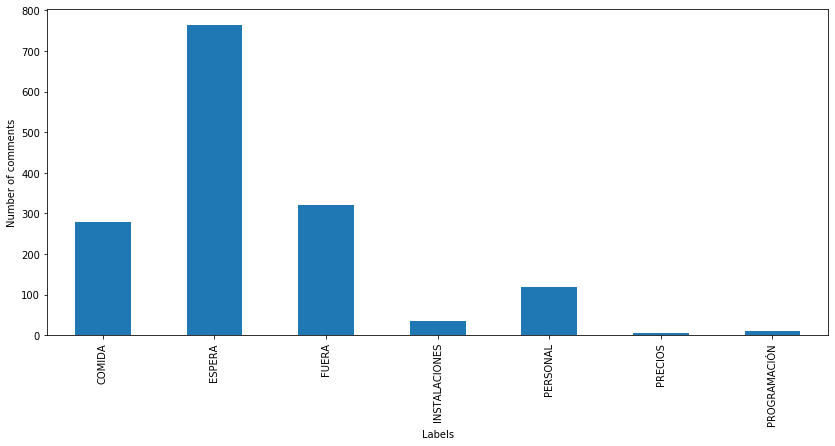

In [208]:

fig = plt.figure(figsize=(14,6))
predictions_df.groupby('Predicted Label')["Comments"].count().plot.bar(ylim=0)
plt.xlabel("Labels")
plt.ylabel("Number of comments")
plt.show()
